In [1]:
import pandas as pd
import script_reglas

import nltk as nltk
from emoji import UNICODE_EMOJI
import unicodedata as unicodedata
import re
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

[NbConvertApp] Converting notebook script_reglas.ipynb to script
[NbConvertApp] Writing 4295 bytes to script_reglas.py


In [2]:
respuestas=pd.read_excel('s3://presidencia-mi-salud/processed/results_export_964.xlsx', encoding='utf-8')

In [3]:
respuestas=respuestas[['Contact UUID', 'URN', 'Name', 'Groups', 'Response 9 (Text) - uncaught']]
respuestas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'texto']

In [4]:
categoria_reglas=pd.DataFrame()
for i in range(0, respuestas.shape[0]):
    respuesta_regla=pd.DataFrame(script_reglas.procesa_reglas(str(respuestas['texto'].iloc[i])), index=[i])
    categoria_reglas=pd.concat([categoria_reglas, respuesta_regla])
respuestas=pd.concat([respuestas[['id_contacto', 'urn', 'nombre_contacto', 'listas']],
                      categoria_reglas], axis=1)

In [5]:
print(respuestas.shape)
respuestas=respuestas.loc[respuestas.texto!='nan']
print(respuestas.shape)

(3045, 9)
(2472, 9)


In [6]:
respuestas.result.value_counts()

modelo           974
like-fb          480
si               309
gracias          184
hola             136
no               114
informacion       96
ok                95
emoji             36
spam              23
twitter-image     13
hasta luego        6
pregunta           4
aborto             2
Name: result, dtype: int64

In [7]:
etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')

In [8]:
respuestas_etiquetas=pd.merge(respuestas, etiquetado[['id_contacto', 'categ_opi', 'Clasificacion final']],how='left',
                              on=['id_contacto'])
print(respuestas_etiquetas.shape)

(2472, 11)


In [9]:
respuestas_etiquetas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result',
       'texto', 'texto_proc', 'wc', 'categ_opi', 'categ_final']

In [10]:
respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']

In [11]:
respuestas_etiquetas.categ_final.loc[respuestas_etiquetas.categ_final.isnull()]=respuestas_etiquetas.categ_opi.loc[respuestas_etiquetas.categ_final.isnull()]

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True).to_csv('compara_etiquetas.csv')

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta,All
categ_final,,,,,,,,,
cancelar,0,0,1,0,0,0,0,4,5
emergencia,5,1,0,0,1,0,0,0,7
informacion,0,42,0,4,0,0,0,2,48
nacimiento,0,0,7,0,0,0,0,0,7
otra,0,0,0,267,1,0,0,3,271
otra_queja,0,0,0,0,140,3,1,1,145
otra_registro,0,0,0,0,0,0,0,7,7
pregunta,0,21,0,2,1,309,3,1,337
pregunta_busca trabajo,0,0,0,1,0,0,57,0,58


In [12]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='cancelar')]='respuesta'
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='otra_registro')]='otra'


/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.texto=='¿Cómo saben que estoy triste?')]='otra'


/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:

pd.crosstab(respuestas_etiquetas.categ_final.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta,All
categ_final,,,,,,,,,
emergencia,5,0,0,0,1,0,0,0,6
informacion,0,42,0,4,0,0,0,2,48
nacimiento,0,0,7,0,0,0,0,0,7
otra,0,1,0,267,1,0,0,10,279
otra_queja,0,0,0,0,140,3,1,1,145
pregunta,0,21,0,2,1,309,3,1,337
pregunta_busca trabajo,0,0,0,1,0,0,57,0,58
pregunta_medica,4,3,0,1,0,9,0,1,18
respuesta,0,2,6,0,0,1,0,67,76


In [15]:
map_fac=pd.factorize(respuestas_etiquetas.categ_final)[1]
respuestas_etiquetas.categ_final=pd.factorize(respuestas_etiquetas.categ_final)[0]
respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final

In [16]:
label_map={0:'otra',
          1:'informacion',
          2: 'nacimiento',
          3: 'respuesta',
          4: 'emergencia',
          5: 'pregunta',
          6: 'pregunta_busca trabajo',
          7: 'otra_queja',
          8: 'pregunta_medica'}

In [17]:
respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final.map(label_map)

## preprocesamiento

In [18]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()

 ### Quitar leading y trailing spaces, quitar puntuacion

In [19]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

In [20]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['texto_proc'].str.count('\\?')>0

In [21]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.replace('[^\w\s]','')

In [22]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

### Capturar emojis

In [23]:
es_emoji=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    es=pd.DataFrame({'es':script_reglas.is_emoji(respuestas_etiquetas['texto'].iloc[i])}, index=[0])
    es_emoji=pd.concat([es_emoji, es], ignore_index=True)
print(es_emoji.shape[0]==respuestas_etiquetas.shape[0])

True


In [24]:
respuestas_etiquetas=respuestas_etiquetas.reset_index(drop=True)

In [25]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, es_emoji], axis=1)

### Quitar emojis que quedan en el texto

In [26]:
sinemojis=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinemojis_i=script_reglas.give_emoji_free_text(respuestas_etiquetas.texto_proc.iloc[i])
    sinemojis_i=pd.DataFrame({'texto':sinemojis_i}, index=[i])
    sinemojis=pd.concat([sinemojis, sinemojis_i])
respuestas_etiquetas['texto_proc']=sinemojis

### Quitar  acentos

In [27]:
sinacentos=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinacentos_i=unicodedata.normalize('NFD', respuestas_etiquetas['texto_proc'].iloc[i]).encode('ascii', 'ignore').decode('utf-8')
    sinacentos_i=pd.DataFrame({'texto':sinacentos_i}, index=[i])
    sinacentos=pd.concat([sinacentos, sinacentos_i])
respuestas_etiquetas['texto_proc']=sinacentos

In [28]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('ola|\n|buena noche|buenos dias|buenos dia|buen dia|buenas noches|buenas tardes|buenas tarde|buen dia|bien dia|buena tardes|buena tarde|saludos|hola', '')

### Procesar dummy de  listas

In [29]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

In [30]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

prueba_listas=respuestas_etiquetas.listas.str.split(expand=True)
lista=[pd.get_dummies(prueba_listas[col]) for col in prueba_listas]

for i in range(0, len(lista)):
    lista[i]['indice'] = lista[i].index
lista=pd.concat(lista, ignore_index=True)
prueba_listas=lista.groupby('indice', as_index=True).agg('sum')

Eliminar listas con pocas personas

In [31]:
prueba_listas=prueba_listas[prueba_listas.sum()[~(prueba_listas.sum()<=3)].keys()]

### TF-DF

In [32]:
stop=nltk.corpus.stopwords.words("spanish")

In [33]:
for i in range(0, np.shape(stop)[0]):
    stop[i]=unicodedata.normalize('NFD', stop[i]).encode('ascii', 'ignore').decode('utf-8')

In [34]:
stemmer = SnowballStemmer("spanish")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [35]:
stemmed=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    stemmed_i=' '.join(tokenize_and_stem(respuestas_etiquetas.texto_proc[i]))
    stemmed_i=pd.DataFrame({'texto':stemmed_i}, index=[i])
    stemmed=pd.concat([stemmed, stemmed_i])
respuestas_etiquetas['texto_proc_stem']=stemmed

In [36]:
#respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.texto_proc.ravel()!='']

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 1]),
                        stop_words=stop)
features = tfidf.fit_transform(respuestas_etiquetas.texto_proc)
labels = respuestas_etiquetas.categ_opi
features.shape

(974, 361)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 2]),
                        stop_words=stop)
features_stem = tfidf.fit_transform(respuestas_etiquetas.texto_proc_stem)
labels = respuestas_etiquetas.categ_final
features_stem.shape

(974, 538)

In [39]:
x_target=respuestas_etiquetas.categ_opi
x_train=respuestas_etiquetas.texto_proc_stem

In [40]:
totalvocab_stemmed = []
totalvocab_tokenized = []
lista_fin=list()
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [41]:
from sklearn.feature_selection import chi2

N = 5
for category_id in sorted(respuestas_etiquetas.categ_final.unique()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# '0':
  . Most correlated unigrams:
. nacional
. llam
. oficin
. escuel
. extension
  . Most correlated bigrams:
. analisis confirm
. porqu antibiot
. bols trabaj
. asi com
. algun numer
  . Most correlated trigrams:
. 
# '1':
  . Most correlated unigrams:
. ofrec
. habl
. pais
. pagin
. embaraz
  . Most correlated bigrams:
. contr bacteri
. baj preci
. informacion porqu
. men lech
. campan vacunacion
  . Most correlated trigrams:
. 
# '2':
  . Most correlated unigrams:
. person
. dias
. may
. nadi
. atend
  . Most correlated bigrams:
. jug yogur
. contr bacteri
. ningun product
. disculp podri
. much graci
  . Most correlated trigrams:
. 
# '3':
  . Most correlated unigrams:
. porfavor
. inform
. doctor
. nadi
. enfermeri
  . Most correlated bigrams:
. ningun product
. disculp podri
. much graci
. deb pas
. com pued
  . Most correlated trigrams:
. 
# '4':
  . Most correlated unigrams:
. per
. atend
. motiv
. dolor
. gratuit
  . Most correlated bigrams:
. acud par
. compr ningun
. ant

### Pruebas número de factores

In [42]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
#import umap
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(context='notebook', style='white', rc={'figure.figsize':(20,20)})


In [43]:
labs=x_target.factorize()[1]
x_target=x_target.factorize()[0]

In [44]:
def loo(i, a):
    features_i=features[i].toarray()
    features_menos_i=np.delete(features.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    Xall=pd.DataFrame(features_menos_i)
    clasificador=RandomForestClassifier()
    loo_predict_proba=pd.DataFrame()
    X_i=pd.DataFrame(features_i)
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier()
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                      pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                     ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [45]:
from datetime import datetime

In [46]:
precision=pd.DataFrame()

for a in range(5, 100):
    inicio=datetime.now()
    loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, a) for i in respuestas_etiquetas.index)

    fin=datetime.now()

    loo_predict_proba=pd.concat(loo_predict_proba)

    loo_predict_proba.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result', 'texto',
                  'texto_proc', 'wc', 'categ_opi', 'categ_final', 'n_interrogacion', 'es',
    'pred_loo', 0, 1, 2, 3, 4, 5, 6, 7, 8]

    precision_i=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
    print(str(a)+ '\n')
    precision_i=pd.DataFrame({'precision':precision_i,
                  'tiempo_entrenamiento':(fin-inicio),'n_loadings':a}, index=[a])
    precision=pd.concat([precision, precision_i],)
    precision.to_csv('precision_loadings.csv')
    print(precision_i)

KeyboardInterrupt: 

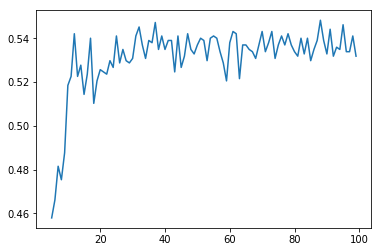

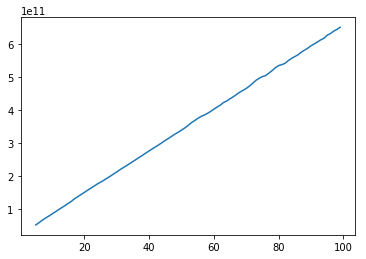

In [132]:
plt.plot(precision.n_loadings, precision.precision)
plt.show()
plt.plot(precision.n_loadings, precision.tiempo_entrenamiento)
plt.show()

In [146]:
pca=TruncatedSVD(n_components=33)
Xall=pca.fit_transform(features)
Xall=pd.DataFrame(Xall)

inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, 33) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

   # print(str(i)+ ' ' +
   #       loo_predict_proba_i[[0, 1, 2, 3, 4, 5, 6, 7, 8]].idxmax(axis=1).astype(str)[i]+ ' ' +
   #       loo_predict_proba_i.categ_final.astype(str)[i] + ' '+loo_predict_proba_i.texto.astype(str)[i])

0:03:52.995486


In [147]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [148]:
loo_predict_proba.columns

Index([    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es',                 0,                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8],
      dtype='object')

In [149]:
loo_predict_proba.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result', 'texto',
                  'texto_proc', 'wc', 'categ_opi', 'categ_final', 'n_interrogacion', 'es',
'pred_loo', 0, 1, 2, 3, 4, 5, 6, 7, 8]

(loo_predict_proba['pred_loo']==x_target).mean()


0.5451745379876797

In [152]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.3585891677650054


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [154]:
pd.crosstab(loo_predict_proba['pred_loo'], x_target)

col_0,0,1,2,3,4,5,6,7,8
pred_loo,,,,,,,,,
0,168,17,1,68,1,54,8,28,11
1,2,6,0,0,0,4,1,3,0
2,0,0,6,0,1,2,0,0,0
3,4,0,0,3,0,2,0,0,1
5,82,22,0,3,3,254,24,38,6
6,4,0,0,0,0,2,21,3,0
7,19,3,0,1,1,18,4,73,0
8,0,0,0,1,0,1,0,0,0


In [155]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['n_interrogacion'].astype(int)

In [252]:

prueba_ensamble=pd.concat([respuestas_etiquetas[['wc', 'es', 'n_interrogacion']],
                           Xall_test], ignore_index=False, axis=1)

### FEATURES DE FLUJOS

In [340]:
flujos=pd.read_csv('s3://presidencia-mi-salud/processed/flujos_peticiones.csv')

In [341]:
flujos.head()

,Unnamed: 0,contact_uuid,flujo_penultimo,flujo_ultimo,nombre,penultimo_tmstmp,texto,ultimo_tmstmp
0,0,3bf0c4bb-d5db-4e0d-ab29-98a7ee6b2b6a,b_consejo_w22_d3,b_development_w22_d4,NaN,2018-08-07T16:02:20.331086Z,NaN,2018-08-08T14:10:16.479863Z
1,1,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,NaN,2018-03-23T18:14:42.214452Z,La solicitud de enviar el SMS por Cobrar a 552...,2018-03-23T18:14:42.955021Z
2,2,7ea8e04b-e8d0-4628-bf35-350a784d5e2f,Fin_SMS,prueba_fb,pedro vallejo,2018-05-17T18:31:38.123141Z,🙅,2018-06-19T18:32:13.198465Z
3,3,3059e012-6fd3-445d-8da4-5fc36d45f8dc,b_concerns_w4_d4,cancelar_misalud,NaN,2018-03-02T15:01:46.787861Z,NaN,2018-03-02T16:25:41.512518Z
4,4,42bf4e3f-a396-4eb7-a987-b76cba779e92,b_nutrition_w78_d4,prueba_fb,Rosy,2018-06-18T14:00:10.181403Z,Hola gordo,2018-06-19T18:32:13.198465Z


In [342]:

flujos=flujos[['contact_uuid', 'flujo_penultimo', 'flujo_ultimo', 'ultimo_tmstmp','penultimo_tmstmp' ]]

In [343]:
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.replace('Z|T', ' ')
flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.replace('Z|T', ' ')

flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.strip()
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.strip()
from datetime import datetime
for i in range(0, flujos.shape[0]):
    if  (flujos.ultimo_tmstmp[i] is np.nan) == False:
        flujos.ultimo_tmstmp[i]=datetime.strptime(flujos.ultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.ultimo_tmstmp[i]=None
    if  (flujos.penultimo_tmstmp[i] is np.nan) == False:
        flujos.penultimo_tmstmp[i]=datetime.strptime(flujos.penultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.penultimo_tmstmp[i]=None

In [344]:
flujos['delta']=flujos.ultimo_tmstmp-flujos.penultimo_tmstmp


In [345]:
delta_horas=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    dias=flujos.delta[i].days
    dias=dias*24
    horas=dias+flujos.delta[i].seconds/3600
    horas=pd.DataFrame({'delta_horas':horas}, index=[i])
    delta_horas=pd.concat([delta_horas, horas])
    

In [346]:
flujos=pd.concat([flujos, delta_horas], axis=1)

In [347]:
horas_ultimos=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    hora_ultimo=int(flujos.ultimo_tmstmp[i].strftime('%H'))
    hora_ultimo=pd.DataFrame({'hora_ultimo':hora_ultimo}, index=[i])
    horas_ultimos=pd.concat([horas_ultimos, hora_ultimo])
flujos=pd.concat([flujos, horas_ultimos], axis=1)   

In [348]:
flujos=flujos[['contact_uuid', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']]
flujos.columns=['id_contacto', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']

In [349]:
respuestas_etiquetas=pd.merge(flujos, respuestas_etiquetas, how='inner',on='id_contacto' )

In [52]:
def loo_masvar(i, a, df_extra):
    df_extra_orig=df_extra
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=pd.DataFrame(features_menos_i)
    
    
    
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [58]:
respuestas_etiquetas=pd.concat([prueba_listas,
           respuestas_etiquetas], axis=1)

In [101]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:04:06.708494


In [103]:
loo_predict_proba=pd.concat(loo_predict_proba)
loo_predict_proba.columns=['12m','all','altopd','cita','con_fecha','cr-grupo-dm','cr-todos',
                           'mialta','no','personal_salud','personal_salud_ow','personal_salud_tw','pregnant',
                           'pregnant_ms','pregnant_ms_ow','pregnant_ms_tw','pregnant_ow','pregnant_tw','puerperium',
                           'puerperium_ms','puerperium_ms_ow','puerperium_ms_tw','puerperium_ow','puerperium_tw',
                           'vacunas','id_contacto','flujo_penultimo','flujo_ultimo','delta_horas',
                           'hora_ultimo','urn','nombre_contacto','listas','cc','result',
                           'texto','texto_proc','wc','categ_opi','categ_final','n_interrogacion','es',
                           'texto_proc_stem', 'pred_loo', 0, 1, 2, 3, 4, 5, 6, 7, 8]

precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
print(precision)

0.5759753593429158


In [104]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.42318761661555965


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [105]:
loo_predict_proba['pred_loo']=loo_predict_proba['pred_loo'].map(label_map)

In [112]:
loo_predict_proba.to_csv('./datos/prueba_loo_58_acc.csv')

In [106]:
pd.crosstab(loo_predict_proba['categ_opi'],loo_predict_proba['pred_loo'] )

pred_loo,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
categ_opi,,,,,,,,
emergencia,0,1,3,1,1,0,0,0
informacion,7,0,14,0,25,0,0,2
nacimiento,0,6,1,0,0,0,0,0
otra,4,0,145,18,67,6,1,38
otra_queja,0,0,30,74,36,5,0,0
pregunta,4,0,49,11,263,8,1,1
pregunta_busca trabajo,1,0,10,3,27,17,0,0
pregunta_medica,0,0,3,1,13,1,0,0
respuesta,0,0,26,1,0,0,0,49


El modelo sólo está clasificando como "información" si dice algo de números de teléfono y son frases cortas

Los nacimientos sí los clasifica bien por la palabra "mi bebé". El único que no cachó fue uno que dijo "ya tiv ami bb"

In [108]:
loo_predict_proba[['flujo_penultimo', 'flujo_ultimo',
                   'delta_horas', 'hora_ultimo',
                   'texto', 'texto_proc', 'texto_proc_stem', 'wc',
                   'categ_opi',
                   'pred_loo']].loc[(loo_predict_proba['categ_opi']=='pregunta_busca trabajo') &
                                   (loo_predict_proba['categ_opi']!=loo_predict_proba['pred_loo'])]

,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,texto,texto_proc,texto_proc_stem,wc,categ_opi,pred_loo
44,uncaught,uncaught,1769.28,19,Hols como están pregunta si soy de las segunda...,hols como estan pregunta si soy de las segunda...,hols com estan pregunt si soy de las segund et...,105,pregunta_busca trabajo,otra_queja
53,NaN,uncaught,NaN,21,"Hace falta más empleos para los nutriólogos, c...",hace falta mas empleos para los nutriologos co...,hac falt mas emple par los nutriolog com se su...,49,pregunta_busca trabajo,pregunta
70,NaN,uncaught,NaN,19,Hola buenas tardes disculpe la molestia mi nom...,disculpe la molestia mi nombre es abraham sa...,disculp la molesti mi nombr es abraham salg ha...,101,pregunta_busca trabajo,otra
91,uncaught,miAlta_General,0,13,"Tuxtla Gutiérrez Chiapas, a 16 de Marzo del 20...",tuxtla gutierrez chiapas a 16 de marzo del 201...,tuxtl gutierrez chiap a de marz del asunt el q...,100,pregunta_busca trabajo,pregunta
93,NaN,uncaught,NaN,14,"hola, buenos dias, me pueden informar como pue...",me pueden informar como puedo obtener mi ser...,me pued inform com pued obten mi servici socia...,16,pregunta_busca trabajo,pregunta
107,uncaught,miAlta_General,0,17,Hola! Soy de cd juarez.soy Nutriologa y me.gus...,soy de cd juarezsoy nutriologa y megustaria a...,soy de cd juarezsoy nutriolog y megustari apli...,20,pregunta_busca trabajo,pregunta
110,NaN,uncaught,NaN,21,"Hola buen dia, disculpe aun no se abre la conv...",disculpe aun no se abre la convocatoria para...,disculp aun no se abre la convocatori par nuev...,13,pregunta_busca trabajo,pregunta
146,NaN,uncaught,NaN,20,Hola buenas tardes! Mi nombre es Elvis Solarte...,mi nombre es elvis srte 26anos soy medico in...,mi nombr es elvis srte 26an soy medic integral...,59,pregunta_busca trabajo,pregunta
152,uncaught,miAlta_General,0,0,O donde envío mi currículum,o donde envio mi curriculum,o dond envi mi curriculum,5,pregunta_busca trabajo,pregunta
158,uncaught,miAlta_General,0,17,estan ocupando vacantes para limpieza,estan ocupando vacantes para limpieza,estan ocup vacant par limpiez,5,pregunta_busca trabajo,otra


In [117]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'

/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= loo_predict_proba['categ_opi'], average='micro')
print(precision)

0.5770020533880903


In [119]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.6550308008213552


In [296]:
pd.crosstab(loo_predict_proba['pred_loo'].map(label_map), loo_predict_proba['categ_opi'])

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,,
emergencia,0,0,0,0,0,1,0,0,0
informacion,0,8,0,2,1,2,1,0,0
nacimiento,1,0,4,0,0,1,0,0,0
otra,0,17,1,138,29,44,7,9,24
otra_queja,2,1,0,22,72,25,5,1,1
pregunta,3,20,2,80,38,256,24,8,3
pregunta_busca trabajo,0,0,0,3,3,6,21,0,0
pregunta_medica,0,0,0,1,1,1,0,0,0
respuesta,0,2,0,33,1,1,0,0,48


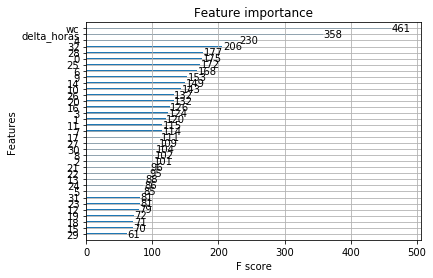

In [275]:
df_extra=respuestas_etiquetas[['delta_horas', 'wc']]

features_menos_i=features.toarray()
pca=TruncatedSVD(n_components=a)
pca=pca.fit(features_menos_i)
features_menos_i=pca.transform(features_menos_i)
Xall=pd.DataFrame(features_menos_i)
Xall=pd.concat([Xall,pd.DataFrame(df_extra.reset_index(drop=True))],axis=1)


clasificador=XGBClassifier()
clasificador=clasificador.fit(X=Xall,y=x_target)

from xgboost import plot_importance

plot_importance(clasificador)

In [157]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [158]:
pd.crosstab(loo_predict_proba['pred_loo_mod'],loo_predict_proba['categ_opi_mod'] )

categ_opi_mod,emergencia,informacion,nacimiento,otra,pregunta,pregunta_medica,respuesta
pred_loo_mod,,,,,,,
informacion,0,6,0,1,5,0,0
nacimiento,1,0,6,0,2,0,0
otra,1,19,0,291,78,7,65
pregunta,4,21,0,128,307,10,1
pregunta_medica,0,0,0,1,2,0,1
respuesta,0,2,1,3,1,1,9


In [160]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.635523613963039


### Doc2Vec

In [42]:
import gensim
from gensim.corpora import Dictionary

In [44]:
tokens=[]
for i in range(0, respuestas_etiquetas.shape[0]):
    tokens.append(tokenize_only(respuestas_etiquetas.texto_proc_stem[i]))


In [45]:
dictionary = Dictionary(tokens)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)


Dictionary(3368 unique tokens: ['a', 'cobr', 'de', 'el', 'envi']...)


In [46]:
#print(dictionary.token2id)

In [47]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

In [48]:
tokens=list()
for i in range(0, respuestas_etiquetas.shape[0]):
    tokens.append(TaggedDocument(tokenize_only(respuestas_etiquetas.texto_proc_stem[i]), [i]))

In [51]:
def doc2vecfeatures(a, tokens):
    tokens_i=tokens[0]
    tokens.pop(0)
    model = gensim.models.doc2vec.Doc2Vec(vector_size=a, min_count=2, epochs=40)
    model.build_vocab(tokens)
    model.train(tokens,
            total_examples=model.corpus_count,
            epochs=model.epochs)
    vec_i=pd.DataFrame(model.infer_vector(tokens_i[0])).transpose()
    vec_i.index=[i]
    tokens.append(tokens_i)
    vec_i=pd.concat([pd.DataFrame(respuestas_etiquetas[['id_contacto', 'texto', 'texto_proc','texto_proc_stem',
                      'wc', 'categ_opi', 'n_interrogacion', ]].loc[i]).transpose(), vec_i], axis=1)
    return(vec_i)

In [52]:
vec=pd.DataFrame()
for i in range(0, len(tokens)):
    print(i)
    vec_i=doc2vecfeatures(30, tokens)
    vec=pd.concat([vec, vec_i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [327]:
from sklearn.metrics.pairwise import cosine_similarity
cos=cosine_similarity(vec[vec.columns[vec.columns.isin([0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29])]])

In [328]:
cos=pd.DataFrame(np.tril(cos, k=-1))



In [335]:
vec.head()

,id_contacto,texto,texto_proc,texto_proc_stem,wc,categ_opi,n_interrogacion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,la solicitud de envi el sms por cobr a ha expi...,24,otra,False,-0.094962,0.008982,0.372797,-0.035794,-0.179471,-0.098642,-0.193829,0.045521,-0.156895,0.144278,0.071030,-0.087622,-0.167600,-0.344233,-0.422326,0.033396,-0.224440,0.082794,-0.249508,-0.471294,-0.170245,-0.043140,-0.062656,0.391886,-0.467811,0.500964,0.377103,-0.176679,-0.071298,0.064004
1,313822ff-7541-4db6-8fe1-a252363000ab,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,te llam y no pud localizart tramit en line tu ...,24,otra,False,-0.040466,-0.165126,0.344995,0.082257,-0.681542,-0.205356,0.053652,0.111890,-0.327112,0.300995,-0.111733,-0.216845,-0.110494,0.131321,-0.520529,0.330311,-0.537741,-0.023052,-0.018561,-0.798093,-0.149589,0.044358,-0.403501,0.251182,-0.370158,0.407737,0.230108,-0.066082,-0.122085,0.034794
2,86962a26-c021-4606-8986-893834ad83bd,59508,59508,,1,informacion,False,0.001627,0.007173,0.003425,0.001496,-0.002545,0.004863,-0.002080,0.013059,0.015455,-0.003885,0.009724,0.000963,0.002268,0.014187,-0.014299,-0.013762,-0.015993,0.011087,0.009272,0.012334,0.015954,0.009972,-0.001284,0.009351,-0.012724,0.004664,-0.011888,0.014822,0.000728,-0.002845
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,Mi bebe,mi bebe,mi beb,2,nacimiento,False,-0.295069,-0.033330,0.098143,0.138864,-0.194244,-0.106861,-0.014758,-0.056768,-0.046228,0.060624,-0.149376,0.039819,-0.044392,0.067084,-0.120124,0.146208,-0.306422,-0.352919,0.114428,-0.072665,0.080986,0.107716,0.078411,0.068301,-0.169929,-0.022147,0.027375,0.234674,0.190778,0.152645
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,si ya cad integr ten fot con la bb segu nos to...,18,respuesta,False,0.050634,0.005810,0.211957,0.234411,-0.198405,-0.164136,-0.099578,0.047901,-0.145030,-0.053938,0.112331,-0.141247,-0.190976,0.196550,-0.111466,0.292792,-0.302052,-0.223547,0.181471,-0.476149,0.028574,-0.080087,-0.034425,0.185250,-0.258200,0.247328,0.143613,0.098811,0.179356,0.251262


In [365]:
def loo_masvar_2vec(i,df_extra):
    df_extra_orig=df_extra
    features_i=vec[[0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29]].loc[1]
    
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=vec[[0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29]].drop(i, axis=0)

    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [366]:
vec.head()

,id_contacto,texto,texto_proc,texto_proc_stem,wc,categ_opi,n_interrogacion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,la solicitud de envi el sms por cobr a ha expi...,24,otra,False,-0.094962,0.008982,0.372797,-0.035794,-0.179471,-0.098642,-0.193829,0.045521,-0.156895,0.144278,0.071030,-0.087622,-0.167600,-0.344233,-0.422326,0.033396,-0.224440,0.082794,-0.249508,-0.471294,-0.170245,-0.043140,-0.062656,0.391886,-0.467811,0.500964,0.377103,-0.176679,-0.071298,0.064004
1,313822ff-7541-4db6-8fe1-a252363000ab,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,te llam y no pud localizart tramit en line tu ...,24,otra,False,-0.040466,-0.165126,0.344995,0.082257,-0.681542,-0.205356,0.053652,0.111890,-0.327112,0.300995,-0.111733,-0.216845,-0.110494,0.131321,-0.520529,0.330311,-0.537741,-0.023052,-0.018561,-0.798093,-0.149589,0.044358,-0.403501,0.251182,-0.370158,0.407737,0.230108,-0.066082,-0.122085,0.034794
2,86962a26-c021-4606-8986-893834ad83bd,59508,59508,,1,informacion,False,0.001627,0.007173,0.003425,0.001496,-0.002545,0.004863,-0.002080,0.013059,0.015455,-0.003885,0.009724,0.000963,0.002268,0.014187,-0.014299,-0.013762,-0.015993,0.011087,0.009272,0.012334,0.015954,0.009972,-0.001284,0.009351,-0.012724,0.004664,-0.011888,0.014822,0.000728,-0.002845
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,Mi bebe,mi bebe,mi beb,2,nacimiento,False,-0.295069,-0.033330,0.098143,0.138864,-0.194244,-0.106861,-0.014758,-0.056768,-0.046228,0.060624,-0.149376,0.039819,-0.044392,0.067084,-0.120124,0.146208,-0.306422,-0.352919,0.114428,-0.072665,0.080986,0.107716,0.078411,0.068301,-0.169929,-0.022147,0.027375,0.234674,0.190778,0.152645
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,si ya cad integr ten fot con la bb segu nos to...,18,respuesta,False,0.050634,0.005810,0.211957,0.234411,-0.198405,-0.164136,-0.099578,0.047901,-0.145030,-0.053938,0.112331,-0.141247,-0.190976,0.196550,-0.111466,0.292792,-0.302052,-0.223547,0.181471,-0.476149,0.028574,-0.080087,-0.034425,0.185250,-0.258200,0.247328,0.143613,0.098811,0.179356,0.251262


In [367]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_2vec)(i, respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

JoblibXGBoostError: JoblibXGBoostError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10555b540, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pepe_.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10555b540, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pepe_.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 22, 3, 34, 515289, tzinfo=tzutc()), 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'session': '0E3798A55CEB4C6B806349C300C855B3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'0E3798A55CEB4C6B806349C300C855B3']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 22, 3, 34, 515289, tzinfo=tzutc()), 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'session': '0E3798A55CEB4C6B806349C300C855B3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'0E3798A55CEB4C6B806349C300C855B3'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 22, 3, 34, 515289, tzinfo=tzutc()), 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'session': '0E3798A55CEB4C6B806349C300C855B3', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A70DC132354343989BD9DEA8C810D987', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='inicio=datetime.now()\n\nloo_predict_proba=Paralle...tas.index)\n\nfin=datetime.now()\n\nprint(fin-inicio)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-367-732c53c99bef>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a1b1f4e80, execution..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a1bec55d0, file "<ipython-input-367-732c53c99bef>", line 3>
        result = <ExecutionResult object at 1a1b1f4e80, execution..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a1bec55d0, file "<ipython-input-367-732c53c99bef>", line 3>, result=<ExecutionResult object at 1a1b1f4e80, execution..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a1bec55d0, file "<ipython-input-367-732c53c99bef>", line 3>
        self.user_global_ns = {'Dictionary': <class 'gensim.corpora.dictionary.Dictionary'>, 'Doc2Vec': <class 'gensim.models.doc2vec.Doc2Vec'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'In': ['', "import pandas as pd\nimport script_reglas\n\nimport...', 500)\npd.set_option('display.max_columns', 500)", "respuestas=pd.read_excel('s3://presidencia-mi-sa...essed/results_export_964.xlsx', encoding='utf-8')", "respuestas=respuestas[['Contact UUID', 'URN', 'N...to', 'urn', 'nombre_contacto', 'listas', 'texto']", 'categoria_reglas=pd.DataFrame()\nfor i in range(0...\n                      categoria_reglas], axis=1)', "print(respuestas.shape)\nrespuestas=respuestas.loc[respuestas.texto!='nan']\nprint(respuestas.shape)", 'respuestas.result.value_counts()', "etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')", "respuestas_etiquetas=pd.merge(respuestas, etique...'id_contacto'])\nprint(respuestas_etiquetas.shape)", "respuestas_etiquetas.columns=['id_contacto', 'ur..., 'texto_proc', 'wc', 'categ_opi', 'categ_final']", "respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']", "respuestas_etiquetas.categ_final.loc[respuestas_..._opi.fillna('missing').astype(str), margins=True)", "respuestas_etiquetas.categ_final.loc[(respuestas...s_etiquetas.categ_final=='otra_registro')]='otra'", "respuestas_etiquetas.categ_final.loc[(respuestas...s.texto=='¿Cómo saben que estoy triste?')]='otra'", "\npd.crosstab(respuestas_etiquetas.categ_final.fi..._opi.fillna('missing').astype(str), margins=True)", 'map_fac=pd.factorize(respuestas_etiquetas.categ_...quetas.categ_opi=respuestas_etiquetas.categ_final', "label_map={0:'otra',\n          1:'informacion',\n... 7: 'otra_queja',\n          8: 'pregunta_medica'}", 'respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final.map(label_map)', "respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()", "respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'N': 5, 'Out': {6: modelo           974
like-fb          480
si    ...4
aborto             2
Name: result, dtype: int64, 11: categ_opi               emergencia  informacion ...    322                      61         82  974  , 14: categ_opi               emergencia  informacion ...    322                      61         82  974  , 37: (974, 361), 38: (974, 538), 54:          0         1         2         3        ... 
0 -0.086504 -0.067287  
0  0.127545 -0.056510  , 56:           0         1
0 -0.707897 -0.109052
0 -0.223786 -0.630157
0 -0.647298 -0.397104, 70: [         0         1         2        3         ...

         28        29  
0  0.044567  0.132699  ,         0         1         2         3         ...

         28        29  
0  0.066653  0.134203  ,         0        1        2         3         4 ...

         28        29  
0  0.048167  0.144315  ,          0         1         2         3        ...

         28        29  
0  0.113685  0.146308  ,          0         1         2         3        ...

         28        29  
0  0.038981  0.118514  ,          0         1         2         3        ...

         28        29  
0  0.085201  0.117086  ,          0         1         2         3        ...

         28        29  
0  0.093814  0.104835  ,          0         1         2         3        ...

         28        29  
0  0.116898  0.081979  ,          0         1         2         3        ...

         28        29  
0  0.119163  0.112954  ,          0         1         2         3        ...

         28        29  
0  0.059745  0.129671  ], 71:          0         1         2         3        ... 
0  0.119163  0.112954  
0  0.059745  0.129671  , 75:           0         1         2         3       ...0   0.093481  0.100482  

[960 rows x 30 columns], ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
        self.user_ns = {'Dictionary': <class 'gensim.corpora.dictionary.Dictionary'>, 'Doc2Vec': <class 'gensim.models.doc2vec.Doc2Vec'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'In': ['', "import pandas as pd\nimport script_reglas\n\nimport...', 500)\npd.set_option('display.max_columns', 500)", "respuestas=pd.read_excel('s3://presidencia-mi-sa...essed/results_export_964.xlsx', encoding='utf-8')", "respuestas=respuestas[['Contact UUID', 'URN', 'N...to', 'urn', 'nombre_contacto', 'listas', 'texto']", 'categoria_reglas=pd.DataFrame()\nfor i in range(0...\n                      categoria_reglas], axis=1)', "print(respuestas.shape)\nrespuestas=respuestas.loc[respuestas.texto!='nan']\nprint(respuestas.shape)", 'respuestas.result.value_counts()', "etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')", "respuestas_etiquetas=pd.merge(respuestas, etique...'id_contacto'])\nprint(respuestas_etiquetas.shape)", "respuestas_etiquetas.columns=['id_contacto', 'ur..., 'texto_proc', 'wc', 'categ_opi', 'categ_final']", "respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']", "respuestas_etiquetas.categ_final.loc[respuestas_..._opi.fillna('missing').astype(str), margins=True)", "respuestas_etiquetas.categ_final.loc[(respuestas...s_etiquetas.categ_final=='otra_registro')]='otra'", "respuestas_etiquetas.categ_final.loc[(respuestas...s.texto=='¿Cómo saben que estoy triste?')]='otra'", "\npd.crosstab(respuestas_etiquetas.categ_final.fi..._opi.fillna('missing').astype(str), margins=True)", 'map_fac=pd.factorize(respuestas_etiquetas.categ_...quetas.categ_opi=respuestas_etiquetas.categ_final', "label_map={0:'otra',\n          1:'informacion',\n... 7: 'otra_queja',\n          8: 'pregunta_medica'}", 'respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_final.map(label_map)', "respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()", "respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'N': 5, 'Out': {6: modelo           974
like-fb          480
si    ...4
aborto             2
Name: result, dtype: int64, 11: categ_opi               emergencia  informacion ...    322                      61         82  974  , 14: categ_opi               emergencia  informacion ...    322                      61         82  974  , 37: (974, 361), 38: (974, 538), 54:          0         1         2         3        ... 
0 -0.086504 -0.067287  
0  0.127545 -0.056510  , 56:           0         1
0 -0.707897 -0.109052
0 -0.223786 -0.630157
0 -0.647298 -0.397104, 70: [         0         1         2        3         ...

         28        29  
0  0.044567  0.132699  ,         0         1         2         3         ...

         28        29  
0  0.066653  0.134203  ,         0        1        2         3         4 ...

         28        29  
0  0.048167  0.144315  ,          0         1         2         3        ...

         28        29  
0  0.113685  0.146308  ,          0         1         2         3        ...

         28        29  
0  0.038981  0.118514  ,          0         1         2         3        ...

         28        29  
0  0.085201  0.117086  ,          0         1         2         3        ...

         28        29  
0  0.093814  0.104835  ,          0         1         2         3        ...

         28        29  
0  0.116898  0.081979  ,          0         1         2         3        ...

         28        29  
0  0.119163  0.112954  ,          0         1         2         3        ...

         28        29  
0  0.059745  0.129671  ], 71:          0         1         2         3        ... 
0  0.119163  0.112954  
0  0.059745  0.129671  , 75:           0         1         2         3       ...0   0.093481  0.100482  

[960 rows x 30 columns], ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/pepe_opi/Documents/GIT/mi-salud/<ipython-input-367-732c53c99bef> in <module>()
      1 inicio=datetime.now()
      2 
----> 3 loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_2vec)(i, respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)
      4 
      5 fin=datetime.now()
      6 
      7 print(fin-inicio)

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             # called before we get here, causing self._jobs to
    785             # grow. To ensure correct results ordering, .insert is
    786             # used (rather than .append) in the following line
    787             self._jobs.insert(job_idx, job)
    788 
--> 789     def dispatch_next(self):
        self = Parallel(n_jobs=-1)
    790         """Dispatch more data for parallel processing
    791 
    792         This method is meant to be called concurrently by the multiprocessing
    793         callback. We rely on the thread-safety of dispatch_one_batch to protect

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
XGBoostError                                       Fri Sep  7 17:03:34 2018
PID: 3890                Python 3.6.3: /Users/pepe_opi/anaconda3/bin/python
...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     implementation using the ``register_parallel_backend`` function.
    127 
    128     By default the following backends are available:
    129 
    130     - 'loky': single-host, process-based parallelism (used by default),
--> 131     - 'threading': single-host, thread-based parallelism,
    132     - 'multiprocessing': legacy single-host, process-based parallelism.
    133 
    134     'loky' is recommended to run functions that manipulate Python objects.
    135     'threading' is a low-overhead alternative that is most efficient for

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     implementation using the ``register_parallel_backend`` function.
    127 
    128     By default the following backends are available:
    129 
    130     - 'loky': single-host, process-based parallelism (used by default),
--> 131     - 'threading': single-host, thread-based parallelism,
    132     - 'multiprocessing': legacy single-host, process-based parallelism.
    133 
    134     'loky' is recommended to run functions that manipulate Python objects.
    135     'threading' is a low-overhead alternative that is most efficient for

...........................................................................
/Users/pepe_opi/Documents/GIT/mi-salud/<ipython-input-365-5de8201a2c3d> in loo_masvar_2vec(i=0, df_extra=      wc  hora_ultimo
0     24           18
1   ...  4
973   12           13

[974 rows x 2 columns])
     32     X_i=features_i
     33     Xall_one_out=Xall
     34     x_target_one_out=pd.DataFrame(x_target).drop(i)
     35     clasificador=XGBClassifier(metrics='auc')
     36     
---> 37     clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
     38     pred=clasificador.predict(X_i)
     39     pred_proba=clasificador.predict_proba(X_i)
     40     loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
     41                                           pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/sklearn.py in fit(self=XGBClassifier(base_score=0.5, booster='gbtree', ...ht=1, seed=None, silent=True,
       subsample=1), X=            0         1         2         3     ...43    NaN          NaN  

[974 rows x 32 columns], y=array([0, 1, 2, 3, 0, 0, 0, 4, 0, 3, 0, 5, 3, 2,...5, 5, 5, 5, 7, 5, 0,
       5, 7, 7, 8, 7, 0, 5]), sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
    501 
    502         self._Booster = train(xgb_options, train_dmatrix, self.n_estimators,
    503                               evals=evals,
    504                               early_stopping_rounds=early_stopping_rounds,
    505                               evals_result=evals_result, obj=obj, feval=feval,
--> 506                               verbose_eval=verbose, xgb_model=None)
        verbose = True
        xgb_model = None
    507 
    508         self.objective = xgb_options["objective"]
    509         if evals_result:
    510             for val in evals_result.items():

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/training.py in train(params={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'metrics': 'auc', 'min_child_weight': 1, ...}, dtrain=<xgboost.core.DMatrix object>, num_boost_round=100, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result={}, verbose_eval=True, xgb_model=None, callbacks=[<function print_evaluation.<locals>.callback>, <function record_evaluation.<locals>.callback>], learning_rates=None)
    199 
    200     return _train_internal(params, dtrain,
    201                            num_boost_round=num_boost_round,
    202                            evals=evals,
    203                            obj=obj, feval=feval,
--> 204                            xgb_model=xgb_model, callbacks=callbacks)
        xgb_model = None
        callbacks = [<function print_evaluation.<locals>.callback>, <function record_evaluation.<locals>.callback>]
    205 
    206 
    207 class CVPack(object):
    208     """"Auxiliary datastruct to hold one fold of CV."""

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/training.py in _train_internal(params={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'metrics': 'auc', 'min_child_weight': 1, ...}, dtrain=<xgboost.core.DMatrix object>, num_boost_round=100, evals=[], obj=None, feval=None, xgb_model=None, callbacks=[<function print_evaluation.<locals>.callback>, <function record_evaluation.<locals>.callback>])
     69                            rank=rank,
     70                            evaluation_result_list=None))
     71         # Distributed code: need to resume to this point.
     72         # Skip the first update if it is a recovery step.
     73         if version % 2 == 0:
---> 74             bst.update(dtrain, i, obj)
        bst.update = <bound method Booster.update of <xgboost.core.Booster object>>
        dtrain = <xgboost.core.DMatrix object>
        i = 0
        obj = None
     75             bst.save_rabit_checkpoint()
     76             version += 1
     77 
     78         assert(rabit.get_world_size() == 1 or version == rabit.version_number())

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/core.py in update(self=<xgboost.core.Booster object>, dtrain=<xgboost.core.DMatrix object>, iteration=0, fobj=None)
    893             raise TypeError('invalid training matrix: {}'.format(type(dtrain).__name__))
    894         self._validate_features(dtrain)
    895 
    896         if fobj is None:
    897             _check_call(_LIB.XGBoosterUpdateOneIter(self.handle, ctypes.c_int(iteration),
--> 898                                                     dtrain.handle))
        dtrain.handle = c_void_p(140348135598240)
    899         else:
    900             pred = self.predict(dtrain)
    901             grad, hess = fobj(pred, dtrain)
    902             self.boost(dtrain, grad, hess)

...........................................................................
/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg/xgboost/core.py in _check_call(ret=-1)
    125     ----------
    126     ret : int
    127         return value from API calls
    128     """
    129     if ret != 0:
--> 130         raise XGBoostError(_LIB.XGBGetLastError())
    131 
    132 
    133 def ctypes2numpy(cptr, length, dtype):
    134     """Convert a ctypes pointer array to a numpy array.

XGBoostError: b'[17:03:34] src/objective/multiclass_obj.cc:43: Check failed: preds.size() == (static_cast<size_t>(param_.num_class) * info.labels.size()) SoftmaxMultiClassObj: label size and pred size does not match\n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000010de7bb89 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x000000010e256f80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'
___________________________________________________________________________

In [368]:
loo_masvar_2vec(1,respuestas_etiquetas[['wc', 'hora_ultimo']] )

XGBoostError: b'[17:04:17] src/objective/multiclass_obj.cc:43: Check failed: preds.size() == (static_cast<size_t>(param_.num_class) * info.labels.size()) SoftmaxMultiClassObj: label size and pred size does not match\n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000010de7bb89 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x000000010e256f80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'

In [364]:
vec[[0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29]].drop(1, axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-0.094962,0.008982,0.372797,-0.035794,-0.179471,-0.098642,-0.193829,0.045521,-0.156895,0.144278,0.071030,-0.087622,-0.167600,-0.344233,-0.422326,0.033396,-0.224440,0.082794,-0.249508,-0.471294,-0.170245,-0.043140,-0.062656,0.391886,-0.467811,0.500964,0.377103,-0.176679,-0.071298,0.064004
2,0.001627,0.007173,0.003425,0.001496,-0.002545,0.004863,-0.002080,0.013059,0.015455,-0.003885,0.009724,0.000963,0.002268,0.014187,-0.014299,-0.013762,-0.015993,0.011087,0.009272,0.012334,0.015954,0.009972,-0.001284,0.009351,-0.012724,0.004664,-0.011888,0.014822,0.000728,-0.002845
3,-0.295069,-0.033330,0.098143,0.138864,-0.194244,-0.106861,-0.014758,-0.056768,-0.046228,0.060624,-0.149376,0.039819,-0.044392,0.067084,-0.120124,0.146208,-0.306422,-0.352919,0.114428,-0.072665,0.080986,0.107716,0.078411,0.068301,-0.169929,-0.022147,0.027375,0.234674,0.190778,0.152645
4,0.050634,0.005810,0.211957,0.234411,-0.198405,-0.164136,-0.099578,0.047901,-0.145030,-0.053938,0.112331,-0.141247,-0.190976,0.196550,-0.111466,0.292792,-0.302052,-0.223547,0.181471,-0.476149,0.028574,-0.080087,-0.034425,0.185250,-0.258200,0.247328,0.143613,0.098811,0.179356,0.251262
5,-0.364267,0.000517,0.057919,0.234246,-0.371279,-0.095204,-0.114311,-0.628785,-0.244202,0.300726,0.078546,0.009604,-0.297722,-0.150147,-0.554686,-0.298134,-0.390192,0.304949,-0.056583,-0.845965,-0.163645,0.315805,-0.161555,0.256253,-0.214940,0.043852,0.001557,0.126820,-0.138192,0.122975
6,-0.223894,-0.266839,0.319510,0.183415,-0.576093,-0.129478,-0.103053,0.190352,-0.365486,0.396147,-0.143425,-0.011724,-0.078345,0.036351,-0.266640,0.186246,-0.678663,0.089498,0.054726,-0.846802,-0.354499,0.209415,-0.440151,0.019642,-0.168013,0.235144,0.022319,0.051066,0.173962,0.089958
7,-0.065887,-0.100066,0.159965,0.031260,-0.486869,-0.121942,-0.103369,0.011798,-0.141776,0.219741,-0.090306,-0.174870,-0.144717,0.068953,-0.249671,0.218645,-0.307775,0.207682,0.221187,-0.526796,-0.257546,0.087724,-0.306882,0.153441,-0.170936,0.208067,0.152649,-0.067074,-0.022154,0.162960
8,-0.244123,0.031398,0.050713,0.084871,-0.116842,-0.173799,0.010205,-0.037914,-0.008996,-0.017098,-0.201977,0.042207,-0.028110,0.076532,-0.147130,0.150222,-0.197296,-0.436076,0.098311,-0.015810,0.070116,-0.000729,0.021735,0.114408,-0.236723,0.011498,0.014978,0.183433,0.213440,0.141666
9,-0.092907,-0.123643,0.147317,-0.006867,-0.352962,-0.116079,-0.035211,0.014491,-0.107165,0.200790,-0.163928,-0.064887,-0.114938,0.083236,-0.134021,0.011474,-0.317903,-0.019419,-0.037414,-0.329440,-0.064316,0.117960,-0.105638,0.036032,-0.098219,0.060149,-0.009933,0.046814,-0.093441,0.026379
10,-0.087401,-0.091143,0.061799,0.086763,-0.235661,-0.161446,0.109078,0.050138,-0.076754,0.096205,-0.162860,-0.079825,-0.023330,0.108378,-0.080016,0.151877,-0.217739,-0.357428,0.034315,-0.096805,0.147601,0.070612,0.084049,-0.014211,-0.061731,-0.046416,0.010419,0.092102,0.075047,-0.002549
